# Derivatives Pricing - European Options

In order to price derivatives, it is first important to understand how the price of the underlying asset evolves over time.
At any time, there are two movements possible for the price. Either it may go up, or it may go down.

Below, we'll try to model the price of an underlying using the binomial tree model.

## Writing a function to construct a binomial tree

In [35]:
import numpy as np

In [36]:
# Stock price, S_ini
# Strike price, K
# Upward movement, u
# Downward movement, d
# Time horizon, T
# No. of steps in the binomial tree = N
# Risk-free rate, r

In [37]:
def binomial_tree(S_ini, T, u, d, N):
    S = np.zeros([N+1, N+1]) # Underlying prices
    for i in range(N+1):
        S[N, i] = S_ini * (u ** i) * (d ** (N-i))

    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
            S[j, i] = S_ini * (u ** i) * (d ** (j-i))
    return S

Let's see the evolution of the price of the underlying if current price is 100, u = 1.2, d = 0.8. Time duration is 1 year and Number of steps, N = 4

In [38]:
stock = binomial_tree(100, 1, 1.2, 0.8, 4)
stock

array([[100.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [ 80.  , 120.  ,   0.  ,   0.  ,   0.  ],
       [ 64.  ,  96.  , 144.  ,   0.  ,   0.  ],
       [ 51.2 ,  76.8 , 115.2 , 172.8 ,   0.  ],
       [ 40.96,  61.44,  92.16, 138.24, 207.36]])

## Adding Call Option Payoffs in the binomial Tree

Let's now extend the above function to compute payoffs of an European call option at maturity.

In [39]:
def binomial_tree_call(S_ini, K, T, u, d, N):
    C = np.zeros([N+1, N+1]) # Call prices
    S = np.zeros([N+1, N+1]) # Underlying prices
    for i in range(N+1):
        C[N, i] = max((S_ini * (u ** i) * (d ** (N-i))) - K, 0)
        S[N, i] = S_ini * (u ** i) * (d ** (N-i))

    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
            S[j, i] = S_ini * (u ** i) * (d ** (j-i))
    return (S, C)

In [40]:
stock, call = binomial_tree_call(100, 90, 10, 1.2, 0.8, 2)
print("Underlying Price Evolution", stock)
print("Call option payoff", call)

Underlying Price Evolution [[100.   0.   0.]
 [ 80. 120.   0.]
 [ 64.  96. 144.]]
Call option payoff [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  6. 54.]]


## Adding risk-neutral probabilities and backward induction of call option value

Once we know the risk-neutral probabilities, we can calculate the value of the call option at each node by backward induction. The value of the call option at any node depends on the expected payoffs of future scenarios (an upward movement and a downward movement) which is then discounted at the risk-free rate.

$C_{t}= e^{-rdt}[p c_{t+1}^u + (1-p) c_{t+1}^d]$

Here, dt is the discounted time period or the time-step.

In [41]:
def binomial_tree_full(S_ini, K, T, r, u, d, N):
    dt = T / N # Time step
    p = (np.exp(r*dt) - d) / (u - d) # risk-neutral probability
    C = np.zeros([N+1, N+1]) # Call option prices
    S = np.zeros([N+1, N+1]) # Underlying price

    for i in range(N+1):
        C[N,i] = max(S_ini * (u**i) * (d ** (N-i))- K, 0)
        S[N,i] = S_ini * (u**i) * (d ** (N-i))

    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
            S[j,i] = S_ini * (u**i) * (d**(j-i))
            C[j, i] = np.exp(-r * dt) * (p * C[j+1, i+1] + (1-p) * C[j+1, i])
    return C[0,0], C,S

In [42]:
call_price, C, S = binomial_tree_full(100, 90, 10, 0, 1.2, 0.8, 10)
print("Underlying price evolution: ", S)
print("Call Option Payoff: ", C)
print("Call option price at t=0: ", "{:.2f}".format(call_price))

Underlying price evolution:  [[100.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [ 80.         120.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [ 64.          96.         144.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [ 51.2         76.8        115.2        172.8          0.
    0.           0.           0.           0.           0.
    0.        ]
 [ 40.96        61.44        92.16       138.24       207.36
    0.           0.           0.           0.           0.
    0.        ]
 [ 32.768       49.152       73.728      110.592      165.888
  248.832        0.           0.           0.           0.
    0.        ]
 [ 26.2144      39.3216      58.9824      88.4736     132.7104
  199.0656     298.5984       0.           0.           0.
    0.        ]
 [ 20.97152     31.45728

## Binomial Tree for Put Options

In [43]:
def binomial_call_full(S_ini, K, T, r, u, d, N):
    dt = T / N # Time step
    p = (np.exp(r*dt) - d) / (u - d) # risk-neutral probability
    C = np.zeros([N+1, N+1]) # Call option prices
    S = np.zeros([N+1, N+1]) # Underlying price

    for i in range(N+1):
        C[N,i] = max(S_ini * (u**i) * (d ** (N-i))- K, 0)
        S[N,i] = S_ini * (u**i) * (d ** (N-i))

    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
            S[j,i] = S_ini * (u**i) * (d**(j-i))
            C[j, i] = np.exp(-r * dt) * (p * C[j+1, i+1] + (1-p) * C[j+1, i])
    return C[0,0], C,S

In [44]:
def binomial_put_full(S_ini, K, T, r, u, d, N):
    dt = T/N
    p = (np.exp(r * dt) - d) / (u - d) # Risk neutral prob
    P = np.zeros([N+1,N+1]) # Put option prices
    S = np.zeros([N+1, N+1]) # Underlying prices

    for i in range(N+1):
        S[N,i] = S_ini * (u ** i) * (d ** (N - i))
        P[N,i] = max(K - S_ini * (u ** i) * (d ** (N-i)), 0)

    for j in range(N-1, -1, -1):
        for i in range(j+1):
            S[j,i] = S_ini * (u ** i) * (d ** (j - i))
            P[j,i] = np.exp(-r * dt) * (p * P[j+1, i+1] + (1 - p) * P[j+1, i])
    return P[0,0], P, S

In [46]:
# calculate price of a put
put_price, P, S = binomial_put_full(100, 90, 10, 0, 1.2, 0.8, 10)
print("Price at t=0 for Put Option is $", "{:.2f}".format(put_price))

Price at t=0 for Put Option is $ 19.38


## Put-Call Parity

In condition of no-arbitrage, the price of the put and the call options must hold the following relationship.

$ C_0 + Ke^{-rT} = S_0 + P_0 $

Let's check whether this is the case for t=0.

In [47]:
round(call_price + 90 * np.exp(-0 * 1), 2) == round(S[0, 0] + put_price, 2)

True

Next we increase the number of steps in the Binomial Tree and check if Put-Call Parity holds.

In [48]:
put_price, P, S = binomial_put_full(100, 90, 1, 0, 1.2, 0.8, 2)
print("Price at t=0 for Put option is $", "{:.2f}".format(put_price))
call_price, C, S = binomial_call_full(100, 90, 1, 0, 1.2, 0.8, 2)
print("Price at t=0 for Call option is $", "{:.2f}".format(call_price))

Price at t=0 for Put option is $ 6.50
Price at t=0 for Call option is $ 16.50


Let's check put-call parity for the node following path 'd' (underlying price S_d = 80), which we can index as [1,0] in the matrix S:

In [49]:
round(C[1, 0] + 90 * np.exp(-0 * 0.5), 2) == round(S[1, 0] + P[1, 0], 2)

True

## Delta Hedging

Delta: It measures change in the price of an option w.r.t. the change in the price of the underlying asset.
One application of delta is that it is used to construct replicating portfolios that are risk-free. We can use delta as a measure to hedge the exposure of our portfolio to underlying price changes. This is known as Delta Hedging.

In [50]:
def call_option_delta(S_ini, K, T, r, u, d, N):
    dt = T / N # Time step
    p = (np.exp(r * dt) - d) / (u - d) # risk-neutral probability
    C = np.zeros([N+1, N+1]) # Call option price
    S = np.zeros([N+1, N+1]) # Underlying price
    Delta = np.zeros([N,N]) # Delta
    for i in range(N+1):
        C[N,i] = max(S_ini * (u ** i) * (d ** (N-i)) - K, 0)
        S[N,i] = S_ini * (u ** i) * (d ** (N-i))
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            S[j,i] = S_ini * (u ** i) * (d ** (j-i))
            C[j,i] = np.exp(-r * dt) * (p * C[j+1,i+1] + (1 - p) * C[j+1,i])
            Delta[j,i] = (C[j+1,i+1] - C[j+1,i]) / (S[j+1,i+1] - S[j+1,i])
    return C[0,0], C, S, Delta

In [51]:
price, call, S, delta = call_option_delta(100, 90, 15, 0, 1.2, 0.8, 15)
print("Underlying: \n", S)
print("Call Price: \n", call)
print("Delta: \n", delta)

Underlying: 
 [[ 100.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.        ]
 [  80.          120.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.        ]
 [  64.           96.          144.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.        ]
 [  51.2          76.8         115.2         172.8           0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.        ]
 [  40.96         61.44         92.16        138.24        207.36
     0.            0.            0.            0.            0.
     0.            0

According to above results, if we want to hedge that call option sale, we need to perform the following steps:
At t=0, we have to buy 0.675 shares.
At t=1, we have to hold 1 share if the price rises, else we have to hold 0.1875 share in case the price falls.
So according to delta, at different nodes we would have to rebalance our portfolio by buying additional quantities or selling some to properly hedge it.

#### Convergence of Value of Option

When we increase the number of steps in the Binomial Tree method, the price of the option also increases monotonically.

In [52]:
price_array = []
for N in [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]:
    price, call, S, delta = call_option_delta(100, 90, 1, 0, 1.2, 0.8, N)
    price_array.append(price)
    print("With N = {:3d}, the price is {:.2f}".format(N, price))

With N =   1, the price is 15.00
With N =  10, the price is 29.38
With N = 100, the price is 70.32
With N = 200, the price is 85.40
With N = 300, the price is 92.33
With N = 400, the price is 95.84
With N = 500, the price is 97.70
With N = 600, the price is 98.71
With N = 700, the price is 99.27
With N = 800, the price is 99.58
With N = 900, the price is 99.76
With N = 1000, the price is 99.86
With N = 1500, the price is 99.99
With N = 2000, the price is 100.00
With N = 2500, the price is 100.00


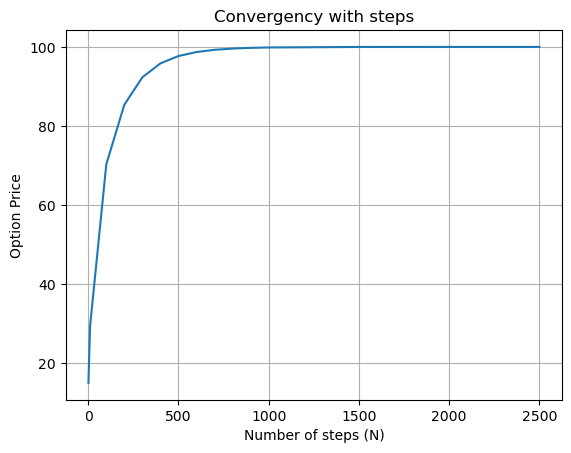

In [53]:
import matplotlib.pyplot as plt

N = [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]
plt.plot(N, np.array(price_array))
plt.title("Convergency with steps")
plt.xlabel("Number of steps (N)")
plt.ylabel("Option Price")
plt.grid(True)
plt.show()

## Matching Volatility and Risk-measures

Next we'll adjust the binomial tree inputs, u and d for the volatility of the underlying asset.
Above we saw how the price of the option converges to the price of the underlying as number of steps, N were increased. We need to have u and d such that they match the variance of the underlying.

The two worlds: risk-neutral and real are different.
When we change from one world to another: only two things changes.
Discount Rate and
Probability

Volatility of the underlying does not change.

In [54]:
def call_option_delta(S_ini, K, T, r, sigma, N):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    print("u:", u)
    print("d:", d)
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )
    return C[0, 0], C, S, Delta

In [55]:
call_price, C, S, delta = call_option_delta(100, 90, 10, 0.1, 0.2, 1000)
print(call_price)

u: 1.0202013400267558
d: 0.9801986733067553
67.45967947506767


Now, let's see for a call option with $K=90$, $r=0\%$, $T=1$, $\sigma=0.3$, price is for different N's:

In [56]:
price_array = []
for N in [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]:
    call_price, C, S, delta = call_option_delta(100, 90, 1, 0, 0.3, N)
    price_array.append(call_price)
    print("With N = {:3d}, the price is {:.2f}".format(N, call_price))

u: 1.3498588075760032
d: 0.7408182206817179
With N =   1, the price is 19.14
u: 1.099514072362268
d: 0.9094926796630575
With N =  10, the price is 17.26
u: 1.030454533953517
d: 0.9704455335485082
With N = 100, the price is 17.02
u: 1.0214398028992784
d: 0.9790102139759748
With N = 200, the price is 17.03
u: 1.0174713778641205
d: 0.9828286296359545
With N = 300, the price is 17.01
u: 1.015113064615719
d: 0.9851119396030626
With N = 400, the price is 17.02
u: 1.0135068117108652
d: 0.986673190989151
With N = 500, the price is 17.01
u: 1.0123227558399348
d: 0.9878272460350745
With N = 600, the price is 17.02
u: 1.0114034635720641
d: 0.9887251092340641
With N = 700, the price is 17.02
u: 1.0106630511200447
d: 0.9894494499346467
With N = 800, the price is 17.01
u: 1.010050167084168
d: 0.9900498337491681
With N = 900, the price is 17.01
u: 1.0095319756211412
d: 0.9905580250538608
With N = 1000, the price is 17.02
u: 1.0077760443023145
d: 0.9922839559976862
With N = 1500, the price is 17.01
u:

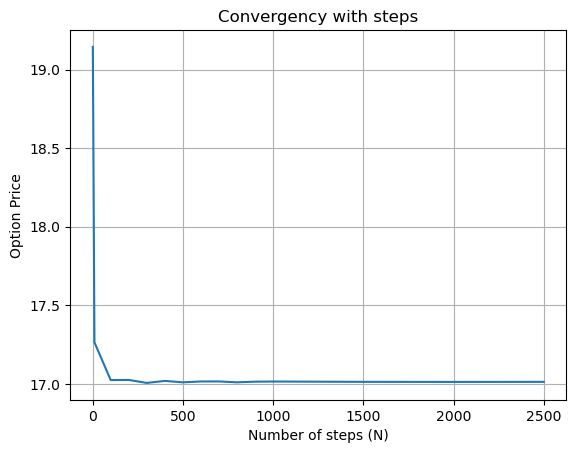

In [57]:
import matplotlib.pyplot as plt

N = [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]
plt.plot(N, np.array(price_array))
plt.title("Convergency with steps")
plt.xlabel("Number of steps (N)")
plt.ylabel("Option Price")
plt.grid(True)
plt.show()

Now the price of the call option converges to a price of $17.01